# Modelling Non-equilibrium, Brownian Particles Using Python


In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import ipywidgets as widgets
%config InlineBackend.figure_format = 'retina'

# Introduction

In this task we will reproduce some results from [Battle et al](http://science.sciencemag.org/content/352/6285/604). The simulation is specified in the Supplementary Material of this paper, [found here.](http://science.sciencemag.org/content/suppl/2016/04/27/352.6285.604.DC1?_ga=2.82543318.1587148702.1535469526-828081955.1535469526)

## Task 3 Probability Flux in State Space of Coupled Brownian Harmonic Oscillators

Subtask 1: Implement the Brownian dynamics simulation of two harmonic oscillators which are connect by a spring:
$$
\frac{dx_1}{dt} = \frac{1}{\zeta}\ k~(x_2-2x_1) + \Gamma_1 \\
\frac{dx_2}{dt} = \frac{1}{\zeta}\ k~(x_1-2x_2) + \Gamma_2
$$
Use the following parameters for the simulation:
- springconstant $k=1$
- friction coefficent $\zeta=18.849$
- timestep $dt=0.1$

The beats should be couppled to heat bathes with two different tempratures T1 and T2. The noises $\Gamma_1$ and $\Gamma_2$ follow a normal distribution with zero mean and variance $\sigma^2 = 2k_B T_1 \tau/\zeta$.

Hint: Calculate first the noise array. Then use a for loop to integrate the dynamamics of the beats. Save the position of each bead as a position touple in a list, e.g. data = [($x_1^0$, $x_2^0$), ($x_1^1$, $x_2^1$), ($x_1^t$, $x_2^t$ )]

In [4]:
def langevin_simulation(steps, T1, T2):
    # fixed parameters
    dt = 0.1
    xi = 18.849
    springk = 1.0
    nstd1 = np.sqrt(2.*T1*dt/xi)
    nstd2 = np.sqrt(2.*T2*dt/xi)
    
    # initialise positions of beads
    x1, x2 = 0., 0.
    
    data = []
    
    # Get random number between 0 and 1
    noise_T1 = np.random.normal(loc=0., scale=nstd1, size=steps)
    noise_T2 = np.random.normal(loc=0., scale=nstd2, size=steps)

    # Time loop
    for ti in range(steps):
        x1 += springk*(x2-2*x1)*dt/xi + noise_T1[ti]
        x2 += springk*(x1-2*x2)*dt/xi + noise_T2[ti]
        
        data.append((x1, x2))
        
    return np.array(data)


## Task 3a Analyze Results
Task: Run the simulation for `N=10000` timesteps with different temperatures `T1` and `T2`. Look at the changes of the trajectories $x_1(t)$, $x_2(t)$ and the center of mass. How would you interpret the results?

In [68]:
N = 500000
data = langevin_simulation(N, T1=1.0, T2=0.5)

Text(0, 0.5, '$x_1$')

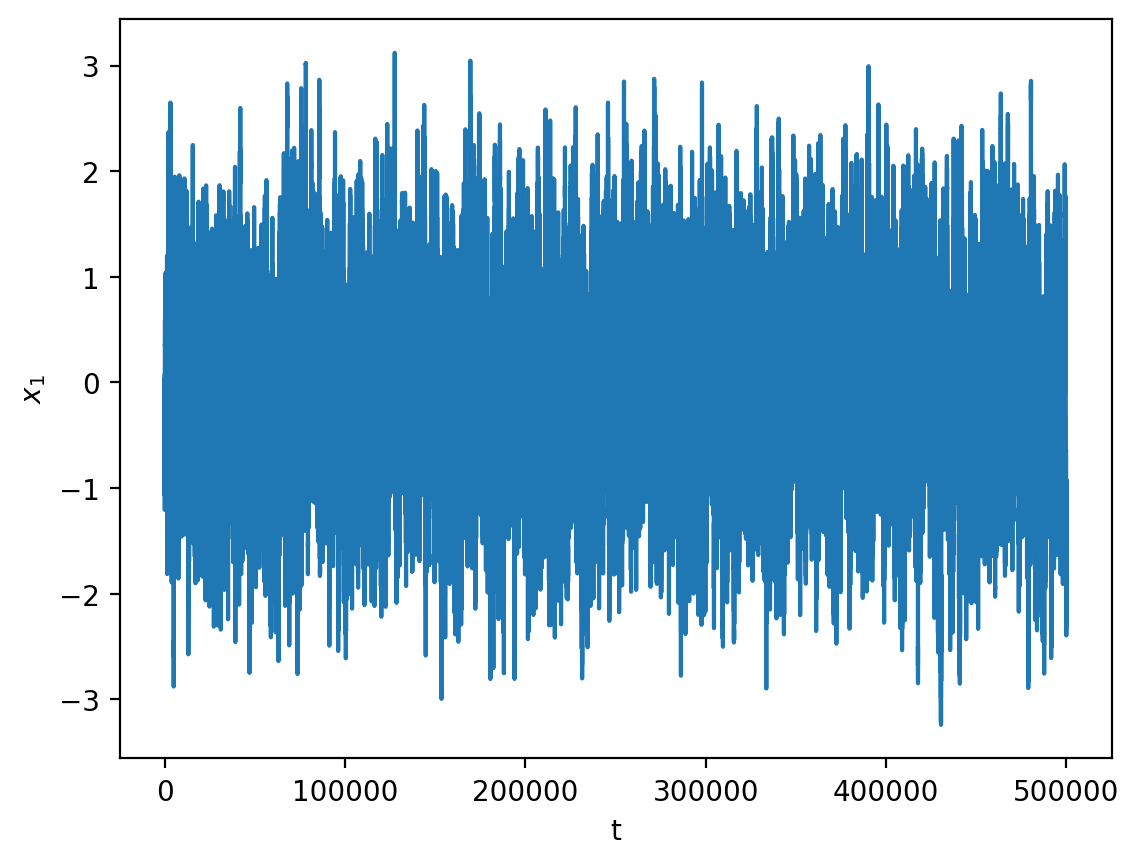

In [69]:
plt.plot(data.T[0], label=r"$x_1$")
plt.xlabel("t")
plt.ylabel(r"$x_1$")

Text(0, 0.5, '$x_2$')

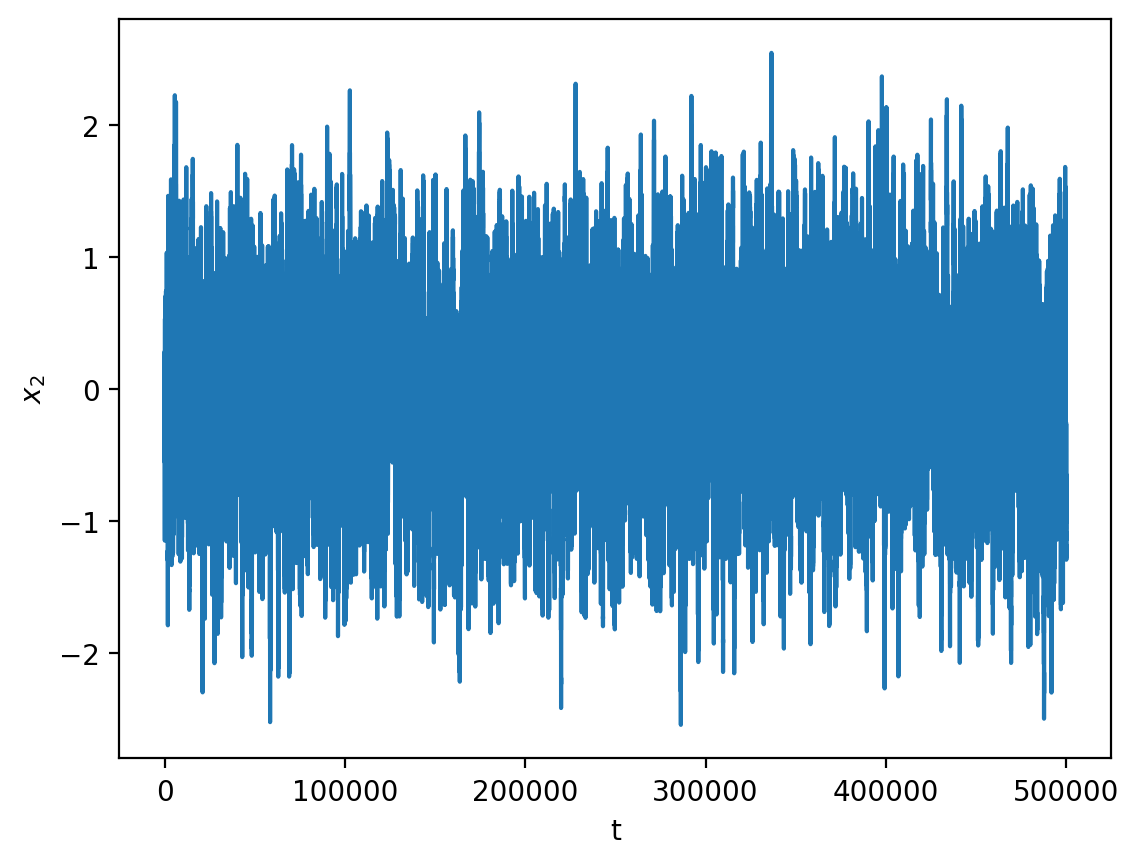

In [70]:
plt.plot(data.T[1])
plt.xlabel("t")
plt.ylabel(r"$x_2$")

Text(0, 0.5, 'N')

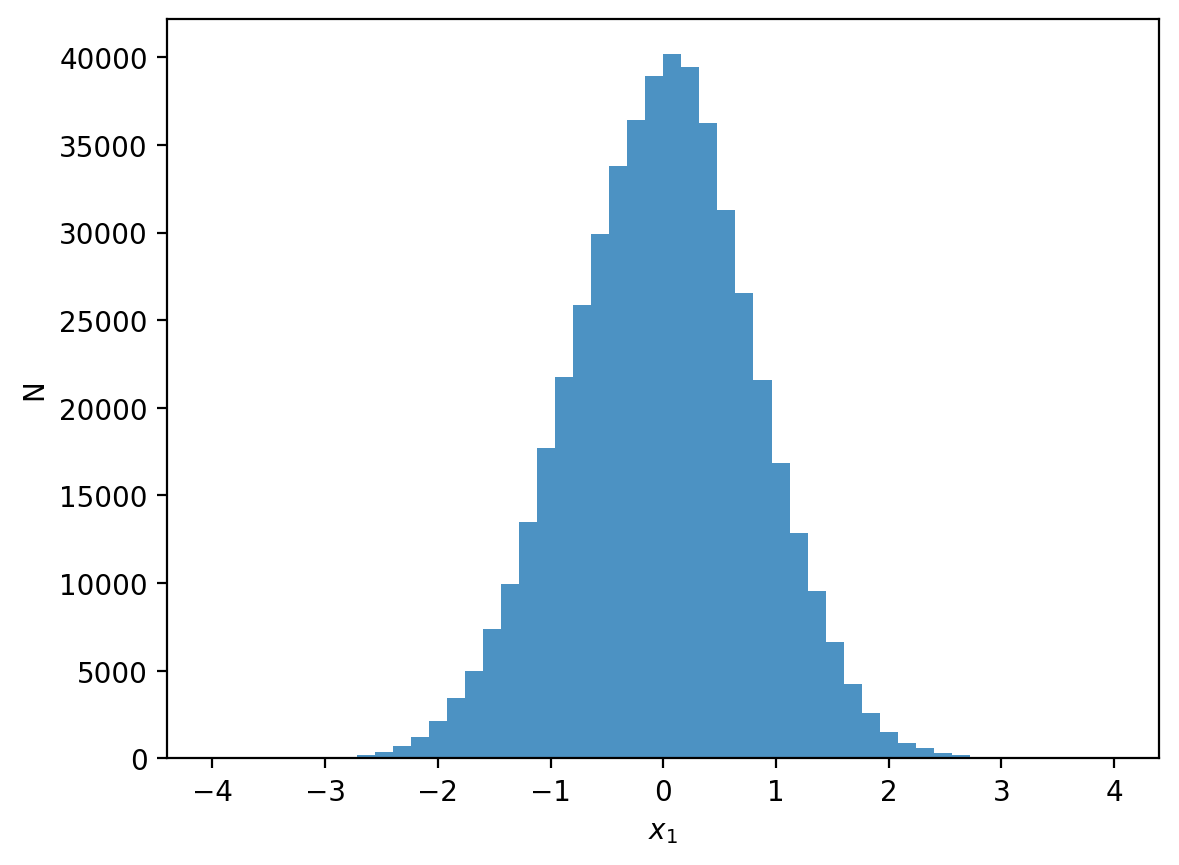

In [74]:
binnum = 50
bins = np.linspace(-4, 4, binnum + 1)

plt.hist(data.T[0], label=r"$x_1$", bins=bins, alpha=0.8)
plt.xlabel(r"$x_1$")
plt.ylabel("N")

Text(0, 0.5, 'N')

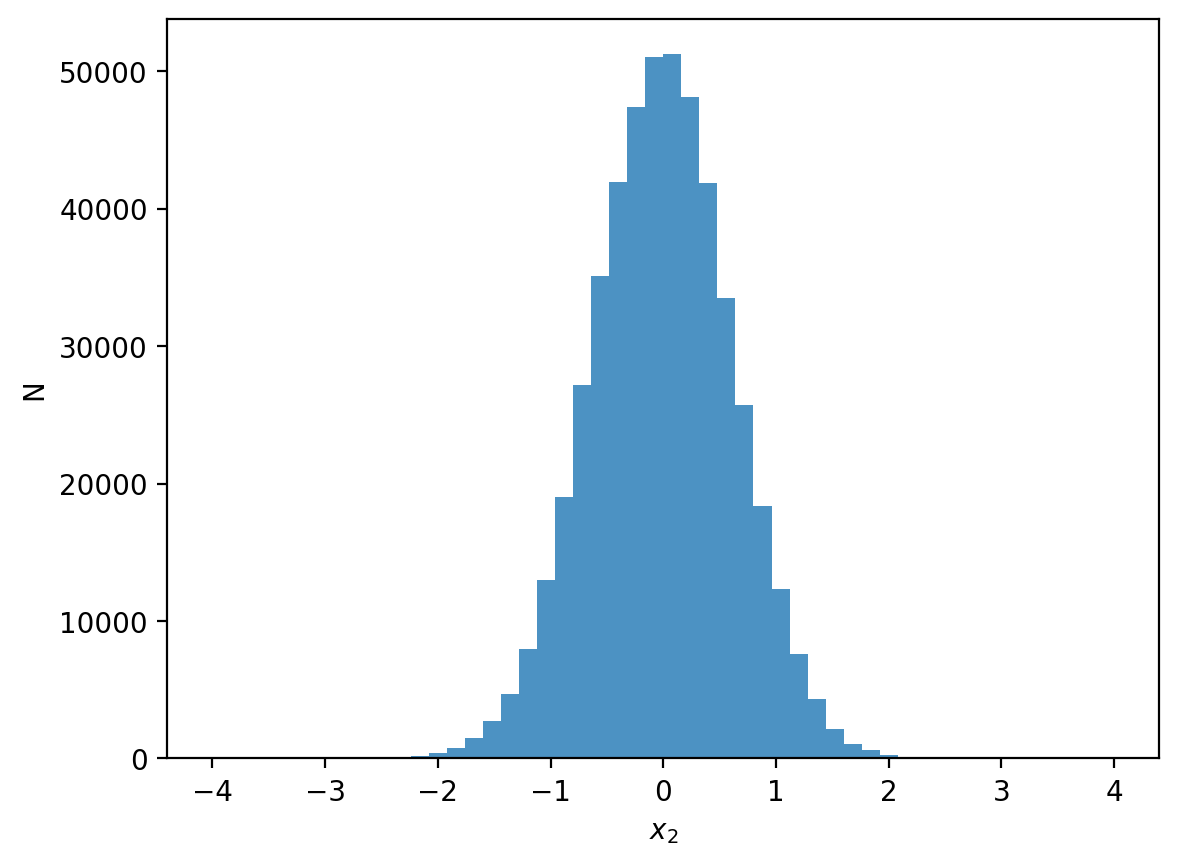

In [75]:
plt.hist(data.T[1],  bins=bins, alpha=0.8)

plt.xlabel(r"$x_2$")
plt.ylabel("N")


Text(0, 0.5, 'N')

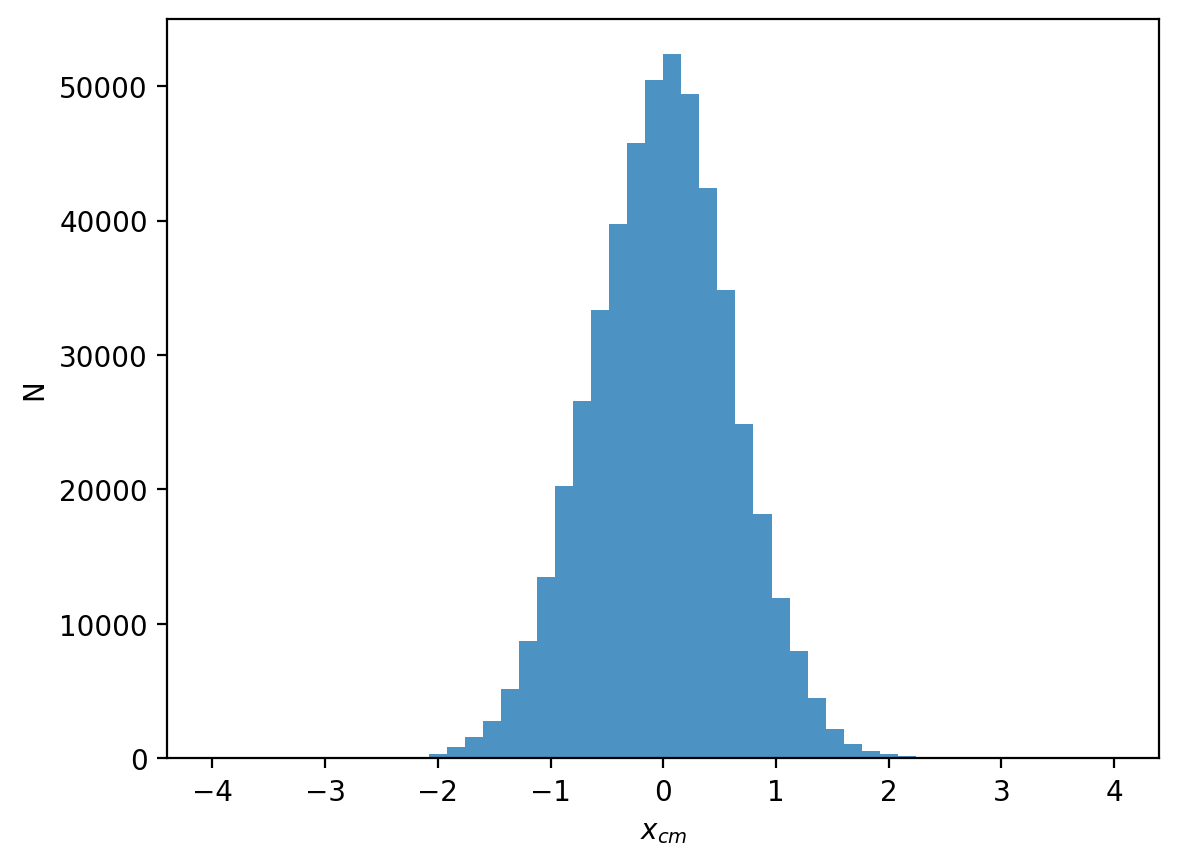

In [76]:

plt.hist((data.T[0] + data.T[1])/2.0, bins=bins, alpha=0.8)
plt.xlabel(r"$x_{cm}$")
plt.ylabel("N")


## Bonus - Interactive Animation of the Oscialltors
A short visualisation of the fluctuating oscillators. Play around with it to get an idea how the simulation results look like

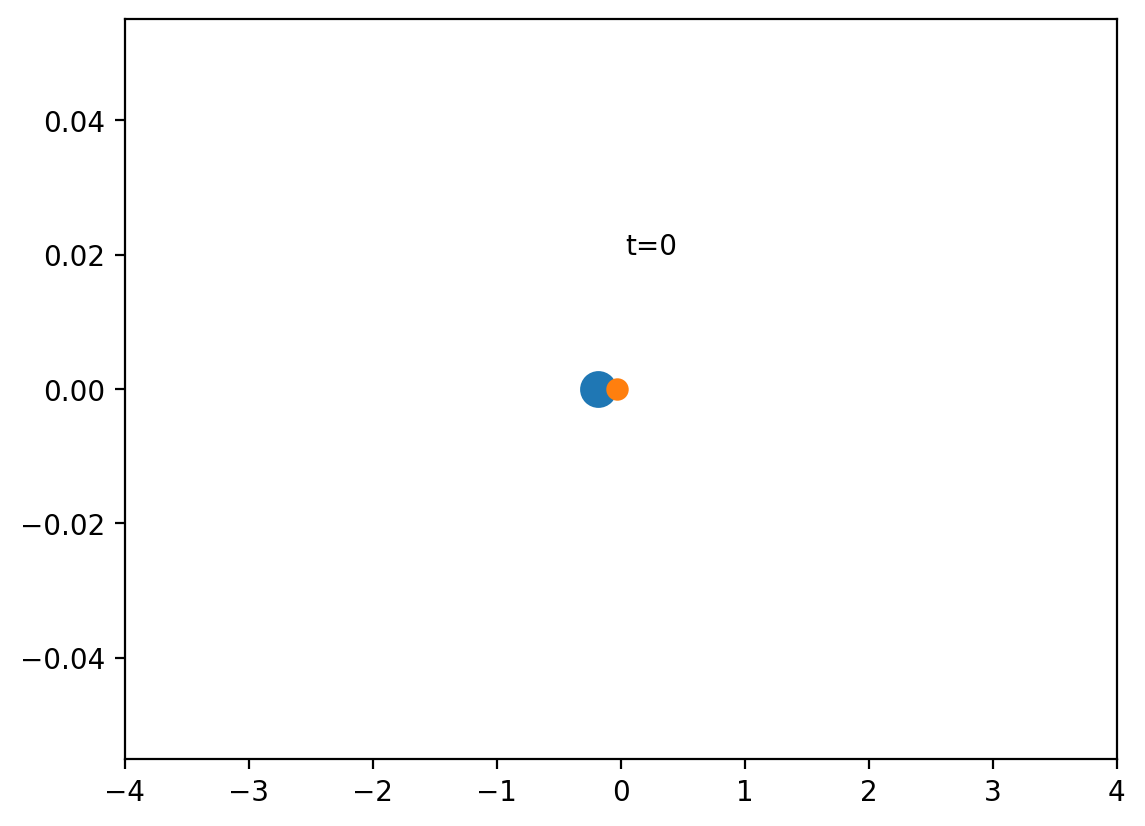

In [8]:
import matplotlib.animation

def animate(t=0):
    fr = data[t]
    l1.set_offsets([fr[0], 0])
    l2.set_offsets([fr[1], 0])
    t1.set_text("t={}".format(t))


fig, ax = plt.subplots()
l1 = ax.scatter([],[], s=150)
l2 = ax.scatter([],[], s=50)
t1 = ax.text(0.04,0.02, "t=0")
ax.set_xlim(-4,4)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=100)

from IPython.display import HTML
HTML(ani.to_jshtml())


## Task 3b Probability flux analysis

Task: Analyze the probability flux for different temperatures. Change the number of bins, number of simulations and the length of the simulation.  Interpret the results.

In [44]:
# Generate Statistics
binnum = 30
bins = np.linspace(-3, 3, binnum + 1)

M = 5 # number of simulations
N = int(10000) # timestemps down

T1 = 1.0 
T2 = 1.5

ensemble = []
for k in range(M):
    ensemble.append(langevin_simulation(N, T1, T2))
ensemble_flatten = np.array(ensemble).reshape(-1,2)

In [45]:
def count_array_sequences(data_list, target_array, follow_array):
    count = 0
    for i in range(len(data_list) - 1):
        # Use np.array_equal for robust comparison
        if np.array_equal(data_list[i], target_array) and np.array_equal(data_list[i + 1], follow_array):
            count += 1
    return count

In [46]:
def get_flux(data, xbins, ybins):
    x1dig = np.digitize(data.T[0], xbins[:-1])-1
    x2dig = np.digitize(data.T[1], ybins[:-1])-1
    digg = np.vstack((x1dig,x2dig)).T
    list_of_all_bins = np.array([[i,j] for i in range(0,len(xbins)-1) for j in range(0,len(ybins)-1)])
    N = len(digg)  # Calculate N once
    flux = []  # Initialize flux as an empty list
    for bin_array in list_of_all_bins:  # Iterate directly over bins
        found_match = False #added a flag to track if match is found
        for j in range(len(digg)):
            if np.array_equal(bin_array, digg[j]):
                f_in_x = count_array_sequences(digg, digg[j] + np.array([1, 0]), digg[j])
                f_in_y = count_array_sequences(digg, digg[j] + np.array([0, 1]), digg[j])
                f_out_x = count_array_sequences(digg, digg[j], digg[j] + np.array([1, 0]))
                f_out_y = count_array_sequences(digg, digg[j], digg[j] + np.array([0, 1]))
                flux.append([(f_in_x - f_out_x), (f_in_y - f_out_y)])
                found_match = True
                break  # Exit inner loop after finding a match
        if not found_match:
            flux.append([0, 0])
    return flux

In [47]:
hist, binsx, binsy = np.histogram2d(ensemble_flatten.T[0], ensemble_flatten.T[1], bins=bins)

fluxes = []
for data in ensemble:
    fluxes.append(get_flux(data, binsx, binsy))
fluxes = np.array(fluxes)
flux = fluxes.mean(axis=0)

In [50]:
# Calculate bin centers
xc = 0.5 * (binsx[:-1] + binsx[1:])

# Create 2D meshgrid
X, Y = np.meshgrid(xc, xc)

# Normalize flux
flux_norm = flux / (2*N)

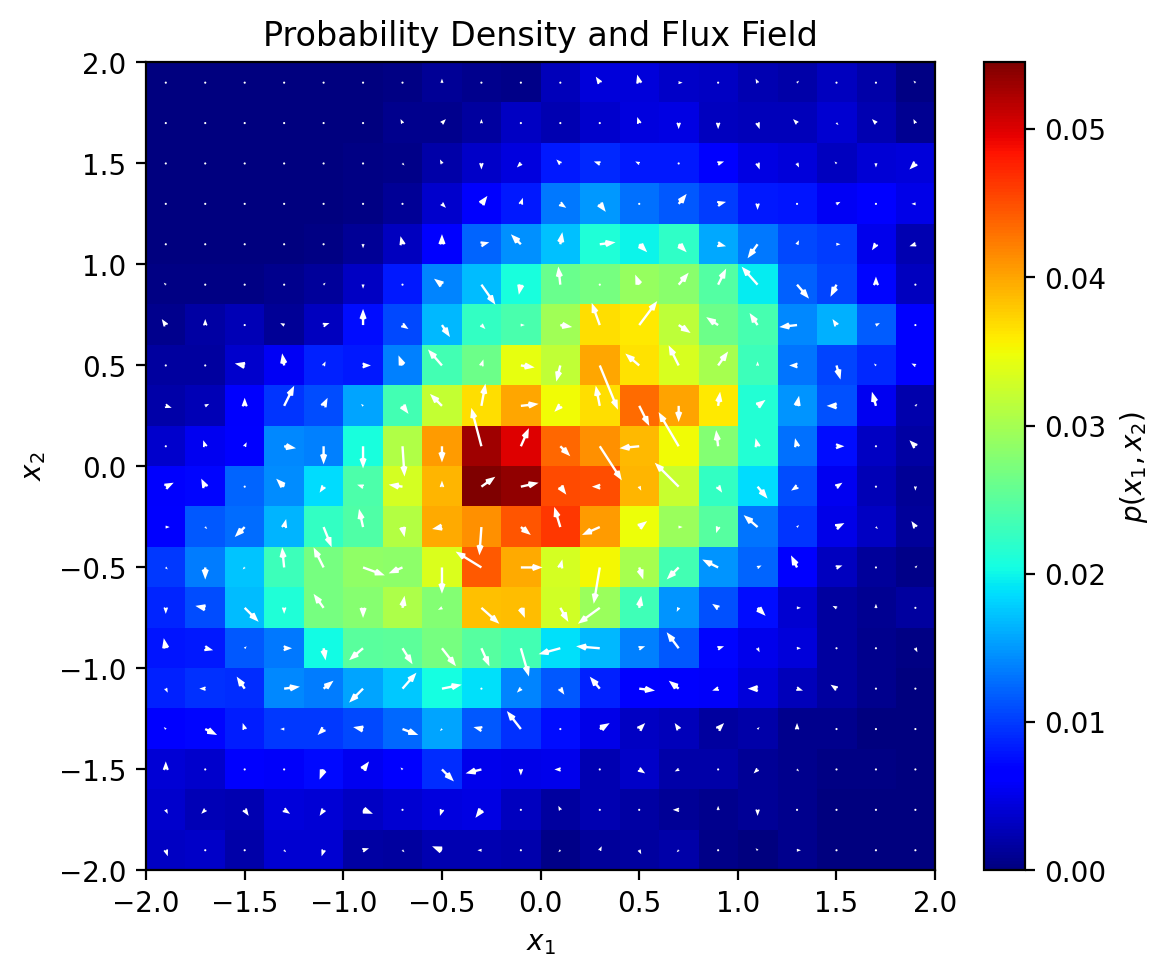

In [51]:
# Assuming flux_norm.shape = (2, Nx, Ny)
u = [flux_norm[i][0] for i in range(len(flux_norm))]
v = [flux_norm[i][1] for i in range(len(flux_norm))]
fig, ax = plt.subplots(figsize=(6, 5))

# Plot histogram
im = ax.imshow(hist/N, extent=(binsx[0], binsx[-1], binsy[0], binsy[-1]),
               cmap="jet", origin="lower", aspect='auto')
plt.colorbar(im, label="$p(x_1,x_2)$")

# Plot flux vectors
ax.quiver(X, Y, u, v, 
          color="white", scale=0.001, scale_units="xy", 
          width=0.003, headwidth=3, headlength=4)

# Labels and limits
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_title("Probability Density and Flux Field")

plt.tight_layout()
plt.show()

In [16]:
data.shape

(1000000, 2)

In [17]:
ensemble_flatten.T[0].shape

(5000000,)

In [ ]:
import numpy as np

def get_flux(data, xbins, ybins):
    # Initialize fluxes.  Crucially, these are 3D arrays.
    flux = np.zeros((len(xbins) - 1, len(ybins) - 1, 2))
    fluxt = np.zeros((len(xbins) - 1, len(ybins) - 1, 2))

    # Digitize positions in phase space.
    # -1 to convert to array indices.
    x1dig = np.digitize(data[:, 0], xbins) - 1
    x2dig = np.digitize(data[:, 1], ybins) - 1
    digg = np.vstack((x1dig, x2dig)).T

    # Calculate the flux.  This is the core logic.
    for i in range(len(data)):
        xbin_index = digg[i, 0]
        ybin_index = digg[i, 1]

        # Check if the particle is within the bin ranges.
        #  Important:  digitize can return an index *outside* the bin range.
        if 0 <= xbin_index < len(xbins) - 1 and 0 <= ybin_index < len(ybins) - 1:
            # Accumulate flux.
            flux[xbin_index, ybin_index, 0] += 1
            flux[xbin_index, ybin_index, 1] += 1

            fluxt[xbin_index, ybin_index, 0] += 1
            fluxt[xbin_index, ybin_index, 1] += 1

    return flux, fluxt

# Example Usage (assuming you have 'ensemble' and 'bins' defined)
# Generate some dummy data for demonstration
ensemble_flatten = np.random.rand(100, 2)  # Example data, shape (100, 2)
bins = 10  # Number of bins for the histogram
ensemble = [np.random.rand(50, 2) for _ in range(5)] # List of 5 data sets, each with shape (50,2)

hist, binsx, binsy = np.histogram2d(ensemble_flatten.T[0], ensemble_flatten.T[1], bins=bins)

fluxes = []
for data in ensemble:
    fluxes.append(get_flux(data, binsx, binsy))
fluxes = np.array(fluxes)
flux, fluxt = fluxes.mean(axis=0) #Unpack the returned tuple

print("Shape of flux:", flux.shape)
print("Shape of fluxt:", fluxt.shape)
# Now 'flux' contains the mean flux.


Shape of flux: (10, 10, 2)
Shape of fluxt: (10, 10, 2)
